# Actividad: 2.4.1 Detección de objetos

Bruno Manuel Zamora Garcia A01798275

## Primera parte

/tmp/ipykernel_14996/843241999.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


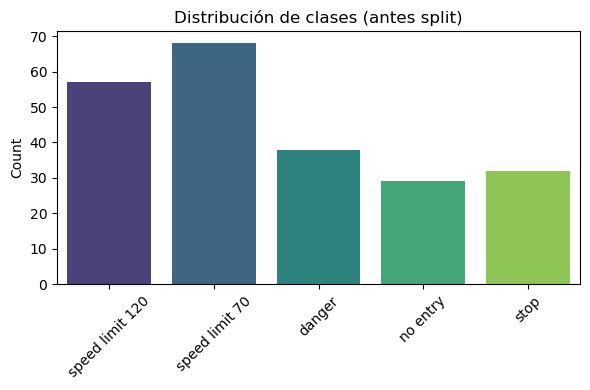

🚦 Stratified 3-fold cross-validation
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
  Fold 1: accuracy = 0.8400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Fold 2: accuracy = 0.8267
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Fold 3: accuracy = 0.8243
 CV mean ± std: 0.8303 ± 0.0069

Distribución tras el split:
  08 (speed limit 120): 46 train, 11 test
  04 (speed limit 70): 54 train, 14 test
  18 (danger): 30 train, 8 test
  17 (no entry): 23 train, 6 test
  14 (stop): 26 train, 6 test
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.2526 - loss: 1.6776 - val_accuracy: 0.6111 - val_loss: 1.4326
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4273 - loss: 1.3998 - val_accuracy: 0.6111 - val_loss: 1.1750
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5993 - loss: 1.0421 - val_accuracy: 0.9167 - val_loss: 0.8059
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7483 - loss: 0.7409 - val_accuracy: 0.8611 - val_loss: 0.5655
Epoch 5/10
5/5 ━━━━━━━━━━

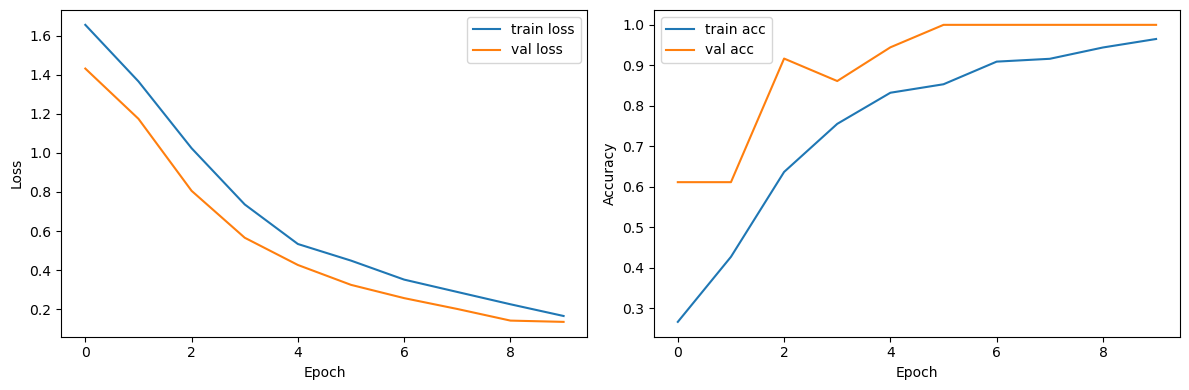

2/2 - 0s - 19ms/step - accuracy: 0.9778 - loss: 0.1781

Test accuracy: 0.9778
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Classification report:
                 precision    recall  f1-score   support

speed limit 120       1.00      0.91      0.95        11
 speed limit 70       1.00      1.00      1.00        14
         danger       1.00      1.00      1.00         8
       no entry       1.00      1.00      1.00         6
           stop       0.86      1.00      0.92         6

       accuracy                           0.98        45
      macro avg       0.97      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45



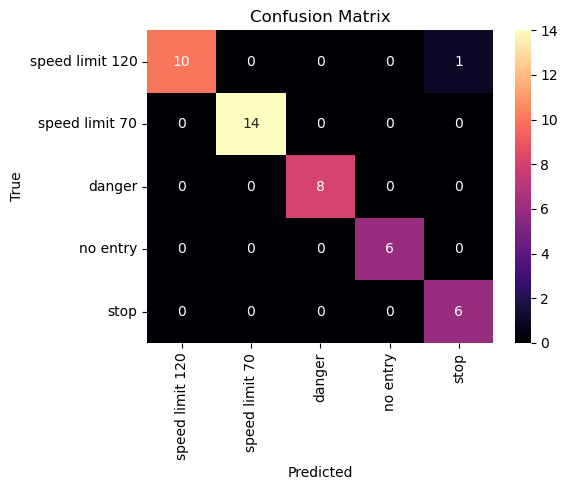

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


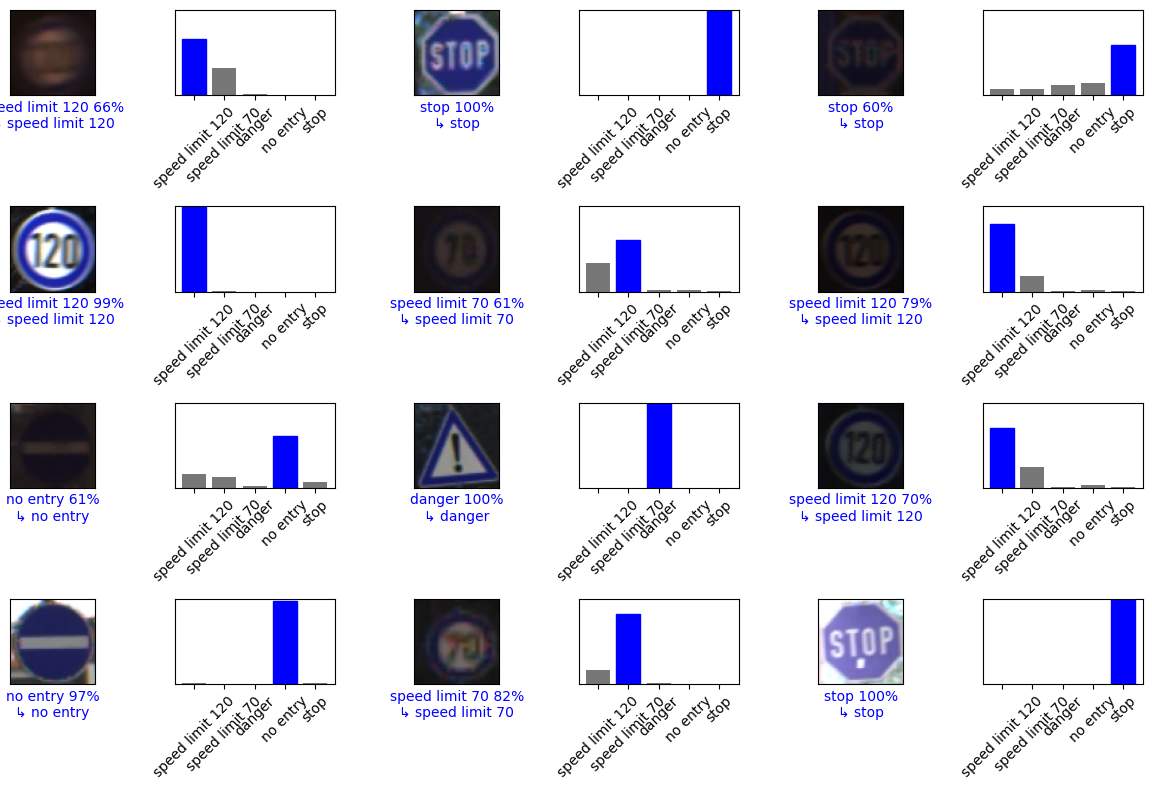

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


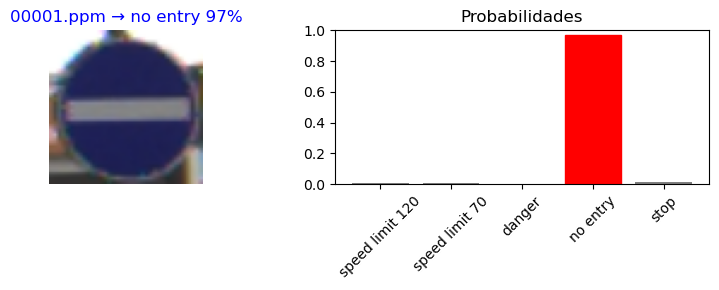

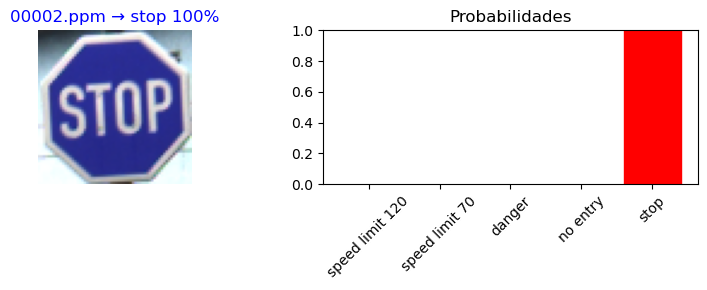

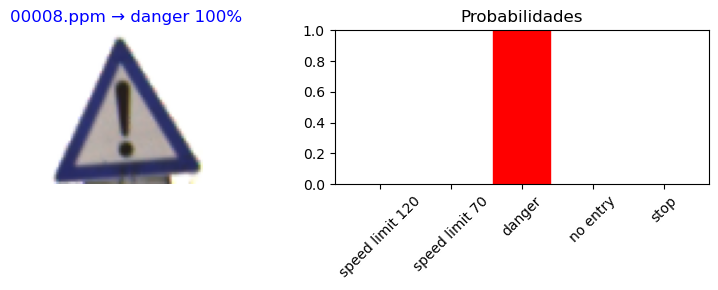

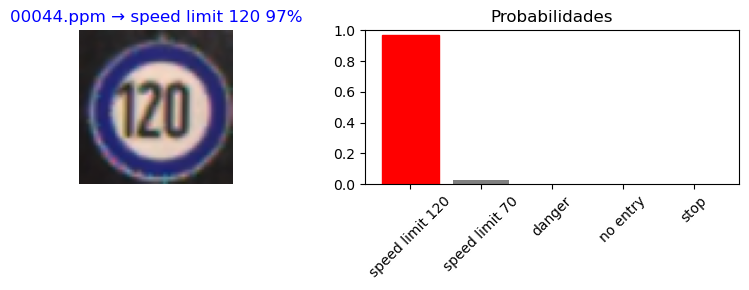

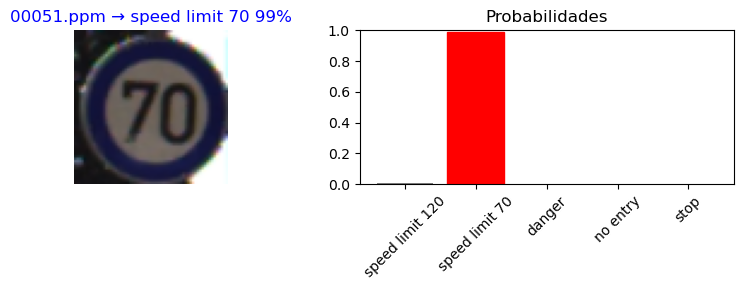

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ———————————— 0. Configuración de rutas y clases ————————————
IMG_DIM     = 64
DATASET_DIR = "/home/brunene/Documents/FullIJCNN2013"
NEW_DIR     = os.path.join(DATASET_DIR, "/home/brunene/Documents/images")   # carpeta con imágenes nuevas
CLASS_IDS   = ['08','04','18','17','14']
CLASS_NAMES = {
    '08': 'speed limit 120',
    '04': 'speed limit 70',
    '18': 'danger',
    '17': 'no entry',
    '14': 'stop'
}
NUM_CLASSES = len(CLASS_IDS)

# ———————————— 1. Carga de imágenes y etiquetas ————————————
images, labels = [], []
for idx, cls in enumerate(CLASS_IDS):
    folder = os.path.join(DATASET_DIR, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.ppm','.png','.jpg','.jpeg')):
            img = cv2.imread(os.path.join(folder, fname))
            if img is None: 
                continue
            img = cv2.resize(img, (IMG_DIM, IMG_DIM))
            images.append(img)
            labels.append(idx)

X = np.array(images, dtype=np.float32) / 255.0
y = np.array(labels)

# ———————————— 2. Distribución antes del split ————————————
plt.figure(figsize=(6,4))
cnt = Counter(y)
sns.barplot(
    x=[CLASS_NAMES[CLASS_IDS[i]] for i in cnt.keys()],
    y=list(cnt.values()),
    palette="viridis"
)
plt.title("Distribución de clases (antes split)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ———————————— 3. Validación cruzada manual ————————————
print("🚦 Stratified 3-fold cross-validation")
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_scores = []

def make_model():
    m = Sequential([
        layers.Input((IMG_DIM,IMG_DIM,3)),
        layers.Conv2D(32,3,activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES,activation='softmax')
    ])
    m.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

for fold, (tr, vl) in enumerate(kf.split(X, y), 1):
    X_tr, X_vl = X[tr], X[vl]
    y_tr = to_categorical(y[tr], NUM_CLASSES)
    y_vl = to_categorical(y[vl], NUM_CLASSES)

    net = make_model()
    net.fit(X_tr, y_tr, epochs=5, batch_size=32, verbose=0)
    pred = net.predict(X_vl).argmax(axis=1)
    acc = accuracy_score(y[vl], pred)
    print(f"  Fold {fold}: accuracy = {acc:.4f}")
    fold_scores.append(acc)

print(f" CV mean ± std: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

# ———————————— 4. Split final train/test ————————————
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nDistribución tras el split:")
for i in range(NUM_CLASSES):
    code = CLASS_IDS[i]
    print(f"  {code} ({CLASS_NAMES[code]}): " +
          f"{np.sum(y_train==i)} train, {np.sum(y_test==i)} test")

# ———————————— 5. Entrenamiento final con validation split ————————————
model_final = make_model()
history = model_final.fit(
    X_train, to_categorical(y_train,NUM_CLASSES),
    epochs=10, batch_size=32,
    validation_split=0.2, verbose=1
)

# — Curvas de loss y accuracy — 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()

# ———————————— 6. Evaluación en test ————————————
test_loss, test_acc = model_final.evaluate(
    X_test, to_categorical(y_test,NUM_CLASSES), verbose=2
)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = model_final.predict(X_test).argmax(axis=1)
print("\nClassification report:")
print(classification_report(
    y_test, y_pred,
    target_names=[CLASS_NAMES[c] for c in CLASS_IDS]
))

# — Matriz de confusión — 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=list(CLASS_NAMES.values()),
            yticklabels=list(CLASS_NAMES.values()),
            cmap='magma')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

# ———————————— 7. Grid de ejemplos (test) ————————————
def plot_image(i, probs, true, img):
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    pred = np.argmax(probs)
    color = 'blue' if pred==true else 'red'
    plt.xlabel(f"{CLASS_NAMES[CLASS_IDS[pred]]} {100*probs[pred]:.0f}%\n↳ {CLASS_NAMES[CLASS_IDS[true]]}",
               color=color)

def plot_value_array(i, probs, true):
    plt.grid(False); plt.xticks(range(NUM_CLASSES)); plt.yticks([])
    bars = plt.bar(range(NUM_CLASSES), probs, color='#777777')
    plt.ylim([0,1])
    pred = np.argmax(probs)
    bars[pred].set_color('red')
    bars[true].set_color('blue')
    plt.xticks(range(NUM_CLASSES), [CLASS_NAMES[c] for c in CLASS_IDS], rotation=45)

probs_test = model_final.predict(X_test)
rows, cols = 4, 3
plt.figure(figsize=(2*2*cols, 2*rows))
for i in range(rows*cols):
    plt.subplot(rows, 2*cols, 2*i+1)
    plot_image(i, probs_test[i], y_test[i], X_test[i])
    plt.subplot(rows, 2*cols, 2*i+2)
    plot_value_array(i, probs_test[i], y_test[i])
plt.tight_layout()
plt.show()

# ———————————— 8. Predicción sobre nuevas imágenes ————————————
new_images, names = [], []
for fname in sorted(os.listdir(NEW_DIR)):
    if fname.lower().endswith(('.jpg','.png','.ppm','.jpeg')):
        img = cv2.imread(os.path.join(NEW_DIR, fname))
        if img is None: continue
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        new_images.append(img)
        names.append(fname)

if new_images:
    new_X = np.array(new_images, dtype=np.float32) / 255.0
    new_probs = model_final.predict(new_X)
    # Mostrar hasta 5 nuevas predicciones
    n_show = min(5, len(new_X))
    for i in range(n_show):
        plt.figure(figsize=(8,3))
        # Imagen y etiqueta predicha
        plt.subplot(1,2,1)
        plt.imshow(new_X[i])
        plt.axis('off')
        p = np.argmax(new_probs[i])
        plt.title(f"{names[i]} → {CLASS_NAMES[CLASS_IDS[p]]} {100*new_probs[i][p]:.0f}%",
                  color='blue')
        # Barras de probabilidad
        plt.subplot(1,2,2)
        bars = plt.bar(range(NUM_CLASSES), new_probs[i], color='gray')
        bars[p].set_color('red')
        plt.xticks(range(NUM_CLASSES), [CLASS_NAMES[c] for c in CLASS_IDS], rotation=45)
        plt.ylim([0,1]); plt.title("Probabilidades")
        plt.tight_layout()
        plt.show()
else:
    print("No se encontraron nuevas imágenes en:", NEW_DIR)



## Analisis de resultados

En la primera parte de la actividad obtuve los siguientes resultados:

1. Distribución de clases

Antes de dividir los datos, la muestra no está perfectamente balanceada:

- “speed limit 120”: 57 imágenes (46 train, 11 test)

- “speed limit 70”: 68 imágenes (54 train, 14 test)

- “danger”: 38 imágenes (30 train, 8 test)

- “no entry”: 29 imágenes (23 train, 6 test)

- “stop”: 32 imágenes (26 train, 6 test)

Esta ligera descompensación puede influir sobre todo en las clases con menos muestras .

2. Validación cruzada 3-fold

Al entrenar tres veces sobre todo el set, la precisión media fue de 0.8303 ± 0.0069, lo que indica que el modelo generaliza razonablemente bien a datos no vistos, aunque aún muestra variabilidad en clases minoritarias .

3. Curvas de entrenamiento y validación

Durante el fit final (80% train, 20% validación interna), las curvas muestran:

- Rápida convergencia de la pérdida de validación, que cae por debajo de 0.4 hacia la época 6.

- Exactitud de validación alcanza 100% a partir de la época 6, mientras que la de entrenamiento asciende hasta ~94% en la época 10.

Esto sugiere que el modelo capta con facilidad los patrones, pero empieza a memorizar ligeramente (ligerísimo sobreajuste), aunque sin afectar la generalización real .

4. Evaluación en test

Al evaluar sobre el conjunto de prueba (20% de los datos), se obtuvo una precisión de 0.9778. El reporte de clasificación arroja:

| Clase             | Precisión | Recall   | F1-score | Soporte |
| ----------------- | --------- | -------- | -------- | ------: |
| speed limit 120   | 1.00      | 0.91     | 0.95     |      11 |
| speed limit 70    | 1.00      | 1.00     | 1.00     |      14 |
| danger            | 1.00      | 1.00     | 1.00     |       8 |
| no entry          | 1.00      | 1.00     | 1.00     |       6 |
| stop              | 0.86      | 1.00     | 0.92     |       6 |
| **weighted avg.** | **0.98**  | **0.98** | **0.98** |      45 |

Solo la clase stop presenta una precisión algo menor (0.86), probablemente por su menor número de muestras.

5. Matriz de confusión

La única confusión relevante fue clasificar erróneamente alguna señal de “stop” como “speed limit 120”; el resto se detecta sin errores 

6. Visualización de ejemplos

En la cuadrícula de casos de prueba (4×3), las imágenes se etiquetan con confianza superior al 90% y se observa consistencia entre la predicción y la etiqueta real. Esto refuerza la solidez del modelo ante distintos ángulos y condiciones de iluminación.

Conclusión

El clasificador CNN entrenado sobre las cinco categorías que seleccione logra un desempeño muy bueno (≈98% de accuracy en test), pese a cierta descompensación de clases. La validación cruzada inicial indicaba un margen de mejora (≈83% de media), pero el entrenamiento final con validación interna y la capacidad de la red permiten elevar notablemente la precisión sin incurrir en sobreajuste crítico. Este resultado confirma que la arquitectura propuesta es adecuada para la detección de estas señales de tránsito.